In [1]:
import sqlite3 as sql
import pandas as pd
from datetime import timedelta

# Función _getKeyVariable_ para identificar si existe un nombre clave de la variable, si no existe retorna ""

In [2]:
def getKeyVariable(var_value):
    try:
        var_value.astype(float)
        return var_value + ":"
    except:
        return ""

# Función getTimestamp para crear el timestamp de la info extraida, si la hora tiene valor 24, corrije

In [3]:
def getTimestamp(tmYear, tmMonth, tmDay, tmHour, tmMin):
    tsDate = str(tmYear) + "/" + str(tmMonth) + "/" + str(tmDay)
    tsDate = pd.to_datetime(tsDate, format="%Y/%m/%d")
    if (tmHour > 23):
        tmHour = 0
        tsDate += timedelta(days=1)
    tsDate = tsDate.replace(hour=tmHour, minute=tmMin)
    return tsDate

# 1. Crear conexión a archivo SQL

In [4]:
myconn = sql.connect("eplusout.sql")
mycursor = myconn.cursor()

## 1.1 Comando SQL para datos de las variables de salida reportadas

In [5]:
comando = """SELECT ReportData.TimeIndex, ReportData.ReportDataDictionaryIndex, Time.DayType, ReportData.Value
  FROM (ReportData INNER JOIN ReportDataDictionary ON ReportData.ReportDataDictionaryIndex = ReportDataDictionary.ReportDataDictionaryIndex) 
  INNER JOIN Time ON ReportData.TimeIndex = Time.TimeIndex"""

## 1.2 Comando SQL para obtener datos del índice y nombre de las variables y otras propiedades

In [6]:
comando_variables = "SELECT ReportDataDictionaryIndex, KeyValue, Name, Units FROM ReportDataDictionary"

## 1.3 Comando SQL para obtener datos de índices de tiempo y representación

In [7]:
comando_tiempo = "SELECT tm.TimeIndex, tm.Year, tm.Month, tm.Day, tm.Hour, tm.Minute FROM Time AS tm"

# 2. Executar comando para datos de las variables

In [8]:
mycursor.execute(comando)

In [9]:
data = mycursor.fetchall()

In [10]:
df = pd.DataFrame(data)

In [11]:
df.columns = ["Time Index", "Variable Index", "Type of Day", "Variable Value"]

Se depura en caso de reportar datos de DesignDay

In [12]:
df2 = df[df["Type of Day"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])]

Se reorganiza tablas acorde al índice de las variables

In [13]:
df3  = df2.pivot(index="Time Index", columns="Variable Index", values=["Variable Value"])

# 3. Executar comando para extraer nombre de variables

In [14]:
mycursor.execute(comando_variables)

In [15]:
data_variables = mycursor.fetchall()

In [16]:
df_variables = pd.DataFrame(data_variables)

In [17]:
df_variables.index = df_variables[0]

Crear nombre compuesto para el reporte de variables que contenga clave, nombre y unidad de medida

In [18]:
df_variables["Variable Name"] = getKeyVariable(df_variables[1]) + df_variables[2] + " (" + df_variables[3] + ")"

In [19]:
variable_cols = []
for i in df3.columns:
    variable_cols.append(df_variables.loc[i[1]]["Variable Name"])

In [21]:
df3.columns = variable_cols
df3

,Electricity:Facility (J),Electricity:Facility (J),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),...,Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W)
Time Index,,,,,,,,,,,,,,,,,,,,,
170,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,45.825577,74.960768,38.481177,55.577169,0.000000,0.000000,14.234707,23.727903
171,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,42.524018,70.120317,36.313872,53.021464,0.000000,0.000000,13.741370,22.983314
172,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,39.254009,65.265602,34.131091,50.374819,0.000000,0.000000,13.244621,22.234024
173,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,35.873512,60.156126,31.959254,47.677206,0.000000,0.000000,12.745373,21.480955
174,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,32.519765,55.015185,29.810937,44.950489,0.000000,0.000000,12.244456,20.724507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61496,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,220.135250,332.714979,154.925395,218.193810,112.809314,146.909860,43.056663,66.669139,49.921813,69.293029
61497,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,204.670192,310.038437,146.227629,206.881016,108.090900,141.150775,39.943071,61.981488,48.593064,67.331922
61498,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.433027,287.646305,137.617520,195.638747,103.376666,135.395706,36.892472,57.378115,47.260107,65.406557


# 4. Executar comando para encontrar datos de tiempo

In [22]:
mycursor.execute(comando_tiempo)

In [23]:
data_timestamp = mycursor.fetchall()

In [24]:
df_timestamp = pd.DataFrame(data_timestamp)

In [25]:
df_timestamp.index = df_timestamp[0]

Retirar los datos de año = 0 (días diseño)

In [26]:
df_yeartm = df_timestamp[df_timestamp[1] != 0]

In [37]:
df_yeartm

,0,1,2,3,4,5,Timestamp
0,,,,,,,
170,170,2006,1,1,0,10,2006-01-01 00:10:00
171,171,2006,1,1,0,20,2006-01-01 00:20:00
172,172,2006,1,1,0,30,2006-01-01 00:30:00
173,173,2006,1,1,0,40,2006-01-01 00:40:00
174,174,2006,1,1,0,50,2006-01-01 00:50:00
...,...,...,...,...,...,...,...
61497,61497,2006,12,31,23,40,2006-12-31 23:40:00
61498,61498,2006,12,31,23,50,2006-12-31 23:50:00
61499,61499,2006,12,31,24,0,2007-01-01 00:00:00


Crear una columna con los timestamp consolidados de los datos del dataframe del tiempo.

In [28]:
df_yeartm["Timestamp"] = df_yeartm.apply(lambda x : getTimestamp(x[1], x[2], x[3], x[4], x[5]), axis = 1)

<ipython-input-28-7adf42ee6722>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yeartm["Timestamp"] = df_yeartm.apply(lambda x : getTimestamp(x[1], x[2], x[3], x[4], x[5]), axis = 1)


In [29]:
time_cols = []
for i in df3.index:
    time_cols.append(df_yeartm["Timestamp"][i])

In [30]:
df3.index = time_cols

# 5. Dataframe con la información extraída del archivo SQL

In [31]:
df3

,Electricity:Facility (J),Electricity:Facility (J),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),Zone Air Temperature (C),Zone Air Relative Humidity (%),...,Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W),Zone Ideal Loads Zone Sensible Cooling Rate (W),Zone Ideal Loads Zone Total Cooling Rate (W)
2006-01-01 00:10:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,45.825577,74.960768,38.481177,55.577169,0.000000,0.000000,14.234707,23.727903
2006-01-01 00:20:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,42.524018,70.120317,36.313872,53.021464,0.000000,0.000000,13.741370,22.983314
2006-01-01 00:30:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,39.254009,65.265602,34.131091,50.374819,0.000000,0.000000,13.244621,22.234024
2006-01-01 00:40:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,35.873512,60.156126,31.959254,47.677206,0.000000,0.000000,12.745373,21.480955
2006-01-01 00:50:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,32.519765,55.015185,29.810937,44.950489,0.000000,0.000000,12.244456,20.724507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 23:30:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,220.135250,332.714979,154.925395,218.193810,112.809314,146.909860,43.056663,66.669139,49.921813,69.293029
2006-12-31 23:40:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,204.670192,310.038437,146.227629,206.881016,108.090900,141.150775,39.943071,61.981488,48.593064,67.331922
2006-12-31 23:50:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.433027,287.646305,137.617520,195.638747,103.376666,135.395706,36.892472,57.378115,47.260107,65.406557
2007-01-01 00:00:00,792000.031471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,174.456379,265.577181,129.101137,184.430195,98.671461,129.645729,33.913731,52.870978,45.925062,63.510961


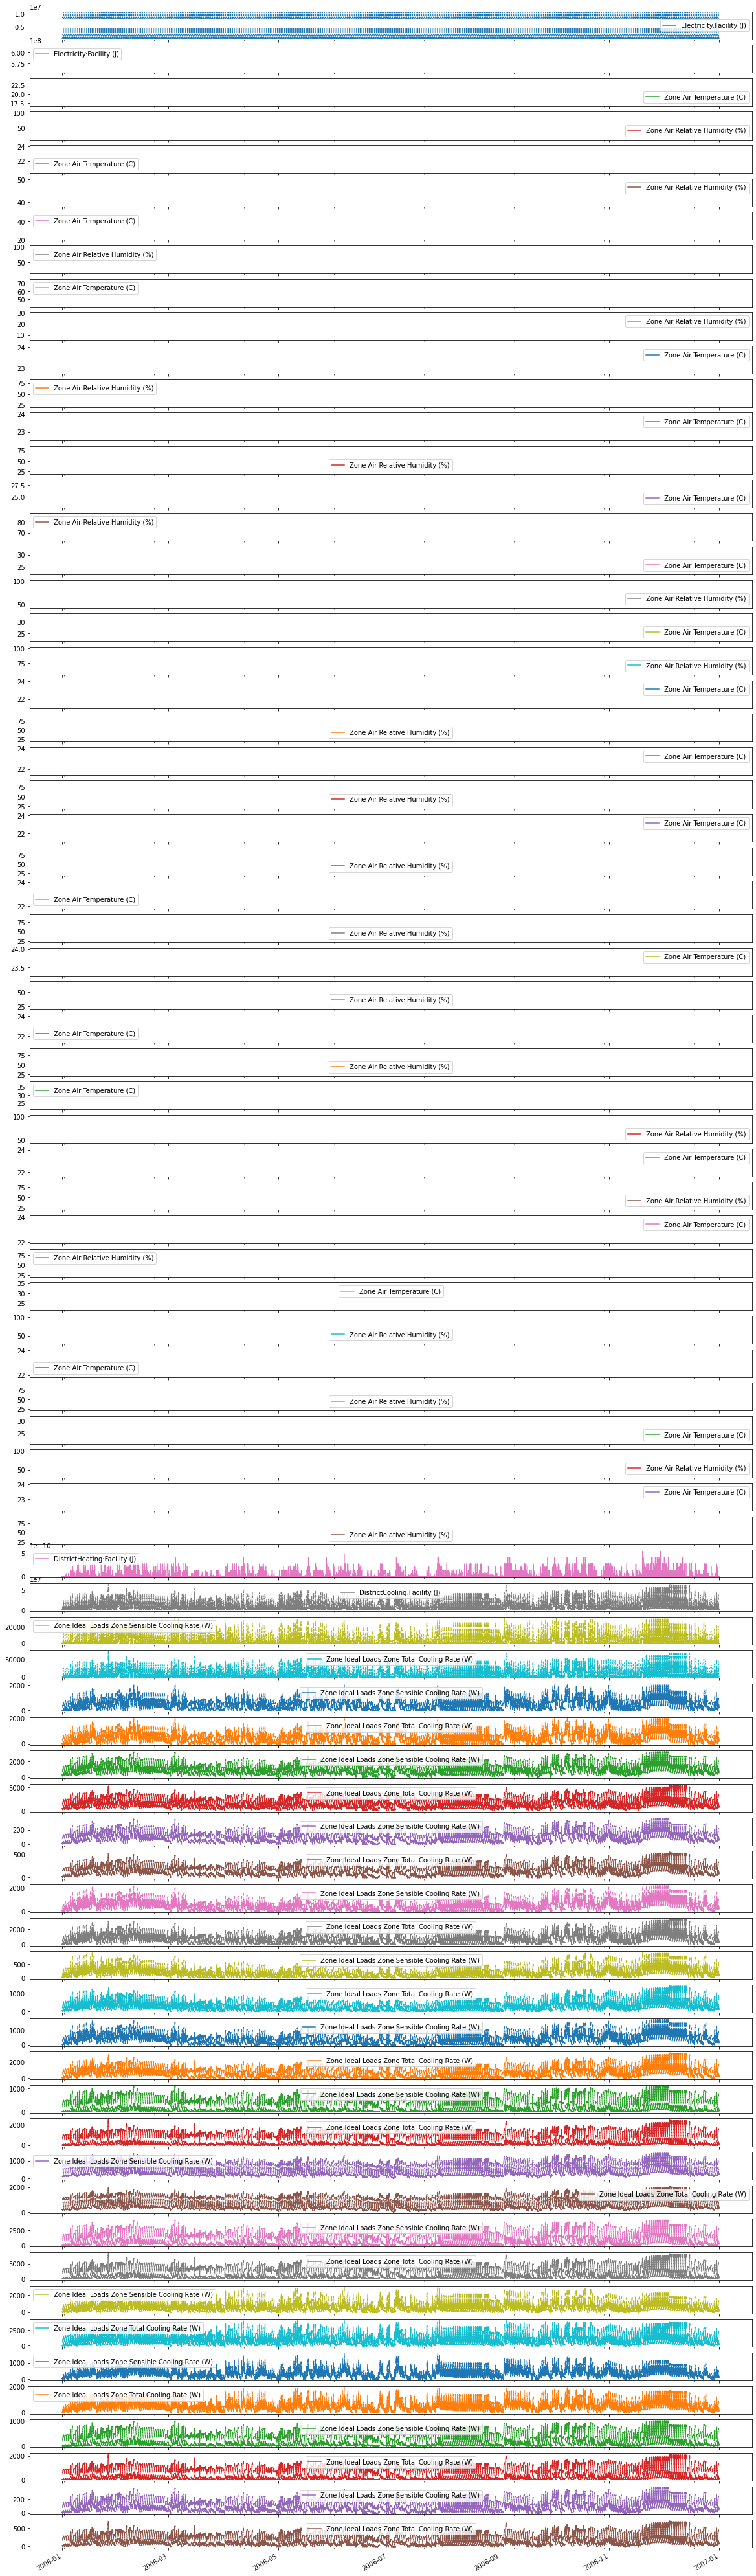

In [34]:
df3.plot(subplots=True,figsize=(20,80));